In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os 
data = []  # List to store image data
labels = []  # List to store labels

# Define a function to extract the person label from the file name
def extract_person_label(file_name):
    return int(file_name.split('.')[0].replace('subject', '')) - 1  # Subtract 1 to make labels start from 0

# Load data and labels
# Assuming the dataset files are in the 'dataset' directory
dataset_dir = 'C:/Users/zaema/Downloads/archive/'

for file_name in os.listdir(dataset_dir):
    img = plt.imread(os.path.join(dataset_dir, file_name))
    # print(img.shape)
    data.append(img.flatten())  # Flatten image into a 1D array
    labels.append(extract_person_label(file_name))

data = np.array(data)
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [2]:
X_train.shape

(132, 77760)

In [3]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))


In [4]:
y_train_onehot.shape

(132, 15)

In [6]:
import numpy as np

class MLP:
    def __init__(self, input_size, layers, activations, learning_rate=0.01, momentum=0.9):
        self.input_size = input_size
        self.layers = layers
        self.activations = activations
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.weights = self._initialize_weights()
        self.prev_gradients = [np.zeros_like(w) for w in self.weights]
        
    def _initialize_weights(self):
        weights = []
        input_neurons = self.input_size
        
        for output_neurons in self.layers:
            w = np.random.randn(input_neurons, output_neurons) * np.sqrt(2. / input_neurons)
            weights.append(w)
            input_neurons = output_neurons
        return weights

    def _activation(self, z, type):
        if type == "sigmoid":
            return 1 / (1 + np.exp(-z))
        elif type == "relu":
            return np.maximum(0, z)
        # add other activation functions if needed

    def _activation_derivative(self, z, type):
        if type == "sigmoid":
            a = self._activation(z, type)
            return a * (1 - a)
        elif type == "relu":
            return (z > 0).astype(float)
        # add derivatives for other activation functions if needed

    def _forward(self, xi):
        activations = [xi]
        sums = []
            
        for i in range(len(self.layers)):
            z = activations[-1] @ self.weights[i]
            a = self._activation(z, self.activations[i])
            sums.append(z)
            activations.append(a)
        return activations, sums
    

    def _backward(self, activations, sums, target):
        errors = [(activations[-1] - target)]
            
        # For the other layers
        for i in reversed(range(len(self.layers) - 1)):
            derivative = self._activation_derivative(sums[i], self.activations[i])
            error = (errors[-1] @ self.weights[i+1].T) * derivative
            errors.append(error)
            
        errors.reverse()
            
        # Compute the gradient for each layer
        for i in range(len(self.layers)):
            gradient = activations[i].T @ errors[i]
                
            # Update with momentum
            gradient = self.learning_rate * gradient + self.momentum * self.prev_gradients[i]
            self.weights[i] -= gradient
                
            # Save the gradient for next iteration
            self.prev_gradients[i] = gradient

    def fit(self, X, y, epochs):
        for epoch in range(epochs):
            for xi, target_i in zip(X, y):
                xi = xi.reshape(1, -1)  # Ensure xi is a row vector
                target_i = target_i.reshape(1, -1)  # Ensure target_i is a row vector
                
                # Forward pass
                activations, sums = self._forward(xi)
                
                # Backward pass
                self._backward(activations, sums, target_i)


    def predict(self, X):
        predictions = []
        for xi in X:
            activations, _ = self._forward(xi)
            predictions.append(activations[-1])
        return np.array(predictions)

    def test(self, X, y):
        predictions = self.predict(X)
        return np.mean(np.argmax(predictions, axis=1) == np.argmax(y, axis=1))


In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV

class MLPClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_size=None, layers=(100,), activations=('relu',), learning_rate=0.01, momentum=0.9, epochs=10):
        self.input_size = input_size
        self.layers = layers
        self.activations = activations
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.epochs = epochs
        self.model = None

    def fit(self, X, y):
        self.model = MLP(self.input_size, self.layers, self.activations, self.learning_rate, self.momentum)
        self.model.fit(X, y, self.epochs)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.test(X, y)




In [8]:
unique_classes = y_train_onehot.shape[1]

mlp_baseline = MLPClassifier(input_size=77760, layers=(100, unique_classes), activations=('relu', 'sigmoid'), learning_rate=0.01, momentum=0.9, epochs=10)
# Fit the model
mlp_baseline.fit(X_train, y_train_onehot)

# Evaluate the model (for example, on a test set)
y_pred_baseline = np.argmax(mlp_baseline.predict(X_test), axis=1)
y_true = np.argmax(y_test_onehot, axis=1)
accuracy_baseline = accuracy_score(y_true, y_pred_baseline)
print(f"Baseline Accuracy: {accuracy_baseline}")

C:\Users\zaema\AppData\Local\Temp\ipykernel_17548\557082694.py:25: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Baseline Accuracy: 0.030303030303030304


In [9]:
# Now you can use GridSearchCV to tune the hyperparameters:
unique_classes = len(np.unique(y_train))
parameters = {
    'layers': [
        (50, unique_classes), 
        (100, unique_classes), 
        # (50, 50, unique_classes), 
        # (100, 50, unique_classes)],
    ],
    'activations': [ ('sigmoid', 'relu'),  ('sigmoid', 'sigmoid')],
    'learning_rate': [0.001, 0.01],
    'momentum': [0.7, 0.9],
    'epochs': [5,10]
}


In [8]:
print(y_train_onehot.shape)
print(y_test_onehot.shape)


(132, 15)
(33, 15)


In [10]:
# Assuming you already predicted using your model:
##without tuning
y_pred = np.argmax(mlp_baseline.predict(X_test), axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  # use 'micro' for micro-average
recall = recall_score(y_true, y_pred, average='macro')  # use 'micro' for micro-average
f1 = f1_score(y_true, y_pred, average='macro')  # use 'micro' for micro-average

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.030303030303030304
Precision: 0.0021645021645021645
Recall: 0.07142857142857142
F1 Score: 0.004201680672268908


c:\Users\zaema\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
from sklearn.model_selection import GridSearchCV

mlp_clf = MLPClassifier(input_size=77760)

grid_search = GridSearchCV(mlp_clf, parameters, cv=3, verbose=1, n_jobs=-1)  # n_jobs=-1 will use all available CPUs
grid_search.fit(X_train, y_train_onehot)

best_clf = grid_search.best_estimator_

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Fitting 3 folds for each of 32 candidates, totalling 96 fits


C:\Users\zaema\AppData\Local\Temp\ipykernel_17548\557082694.py:25: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Best parameters found:  {'activations': ('sigmoid', 'relu'), 'epochs': 5, 'layers': (100, 15), 'learning_rate': 0.001, 'momentum': 0.7}
Best cross-validation score: 0.08


In [12]:
#with tuning
best_mlp = grid_search.best_estimator_

y_pred = np.argmax(best_mlp.predict(X_test), axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.06060606060606061
Precision: 0.0047619047619047615
Recall: 0.07142857142857142
F1 Score: 0.008928571428571428


C:\Users\zaema\AppData\Local\Temp\ipykernel_17548\557082694.py:25: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
c:\Users\zaema\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\zaema\AppData\Local\Temp\ipykernel_17548\557082694.py:25: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


[[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 3 0 0 0 0 0]]


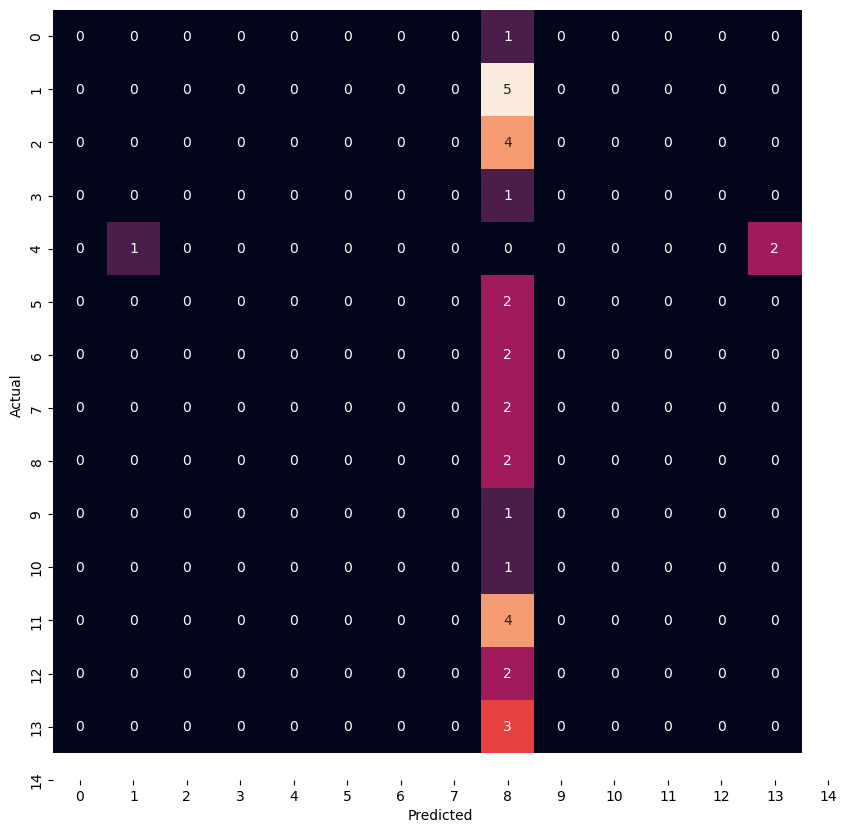

In [14]:
#plot confusion matrix for training data
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(best_mlp.predict(X_test), axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

cm = confusion_matrix(y_true, y_pred)
print(cm)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False)
plt.xticks(np.arange(unique_classes) + 0.5, np.arange(unique_classes))
plt.yticks(np.arange(unique_classes) + 0.5, np.arange(unique_classes))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
